In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Naive Bayes Continuous Case

/Users/jamesmontgomery/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: covariance is not positive-semidefinite.


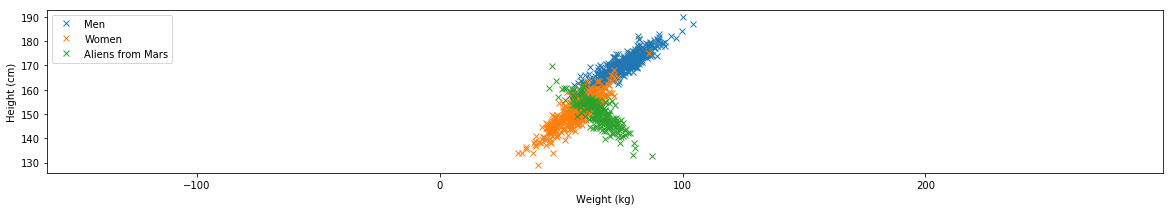

In [2]:
# initialize our data
n = 1000
X = np.zeros((n,2)) 
y = np.zeros((n, 3))

# class probabilities
true_theta = [0.4, 0.4, 0.2] 

#class means
true_means = [
              [75, 170], #men
              [55, 150], #women
              [65, 150]  #aliens
             ]

#class covariances
true_cov = [[[80, 50], [-5, 2]],
            [[60, 50], [-8, 2]],
            [[60, -50], [8, 2]]
           ]

for i in xrange(n):    
    # sample a class label
    y[i,:] = np.random.multinomial(1, true_theta, size=1).flatten()
    c = np.argmax(y[i,:])
    # sample the corresponding features.
    X[i,:] = np.random.multivariate_normal(true_means[c], true_cov[c], 1).flatten()
    
plt.figure(figsize=(20,3))
plt.plot(X[y[:,0]==1,0], X[y[:,0]==1,1], 'x', label='Men')
plt.plot(X[y[:,1]==1,0], X[y[:,1]==1,1], 'x', label='Women')
plt.plot(X[y[:,2]==1,0], X[y[:,2]==1,1], 'x', label='Aliens from Mars')
plt.axis('equal')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.legend(loc=2)
plt.show()

In [65]:
class naive_bayes_gaussian(object):
    def __init__(self):
        self.means = []
        self.std = []
        self.n_classes = None
        
    def preprocess(self,x,y=None):
        if len(x.shape) == 1:
            x = x.reshape(-1,1)
        if y is not None:
            if len(y.shape) == 1:
                n_classes = len(np.unique(y))
                y = y.reshape(-1)
                y = np.eye(n_classes)[y]
            else:
                n_classes = y.shape[1]
        else:
            n_classes = None
        return x,y,n_classes    
        
    def train(self,x,y):
        x,y, self.n_classes = self.preprocess(x,y)
        
        for i in range(self.n_classes):
            self.means.append( x[y.argmax(axis=1) == i].mean(axis=0) )
            self.std.append(np.diag( x[y.argmax(axis=1) == i].std(axis=0) )) 
            
    def predict(self,x):
        x,_,_ = self.preprocess(x)
        probs = []
        for i in range(self.n_classes):
            p = multivariate_normal.pdf(x,mean=self.means[i],cov=self.std[i])
            probs.append(p)
        probs = np.array(probs)
        return probs.T

In [66]:
model = naive_bayes_gaussian()
model.train(X,y)
predictions = model.predict(X).argmax(axis=1)

In [67]:
1.0 * y[y.argmax(axis=1) == predictions].shape[0] / y.shape[0]

0.816

### Naive Bayes Discrete Case

https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

In [2]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import string

In [4]:
df = pd.read_csv("spam.csv").iloc[:,:2]
df.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
df['label'] = df['labels'].map({'ham': 0, 'spam': 1})
df = df.sample(frac=1).reset_index().iloc[:,2:]
train, test = train_test_split(df, test_size=0.3)

In [38]:
train_data = {'messages':np.array(train.message.values),
              'labels':np.array(train.label.values)}
test_data = {'messages':np.array(test.message.values),
              'labels':np.array(test.label.values)}

In [62]:
class naive_bayes_discrete(object):
    def __init__(self, train_data):
        self.mail = train_data['messages']
        self.labels = train_data['labels']
        
    def train(self,method='simple'):
        if method == 'tf-idf':
            pass
        
        self.count_tf_and_idf()
        
        self.spam_prob = {}
        self.ham_prob = {}
        
        for word in self.spam_tf:
            self.spam_prob[word] = 1.0*(self.spam_tf[word] + 1) / (self.spam_words + len(self.spam_tf.keys()))
        for word in self.ham_tf:
            self.ham_prob[word] = 1.0*(self.ham_tf[word] + 1) / (self.ham_words + len(self.ham_tf.keys()))
        
        self.spam_mail_prob = 1.0*self.spam_count / self.message_count
        self.ham_mail_prob = 1.0*self.ham_count / self.message_count
        
    def count_tf_and_idf(self):
        self.message_count = self.mail.shape[0]
        self.spam_count = self.labels[self.labels == 1].shape[0]
        self.ham_count = self.labels[self.labels == 0].shape[0]
        
        self.spam_words = 0
        self.ham_words = 0
        
        self.spam_tf = {}
        self.ham_tf = {}
        self.spam_idf = {}
        self.ham_idf = {}
        
        for i in range(self.message_count):
            message = self.mail[i]
            message = self.preprocess_message(message)
            
            count = [] # has word occured in message (IDF)
            for word in message:
                if self.labels[i]:
                    self.spam_tf[word] = self.spam_tf.get(word,0) + 1
                    self.spam_words += 1
                else:
                    self.ham_tf[word] = self.ham_tf.get(word,0) + 1
                    self.ham_words += 1
                if word not in count:
                    count.append(word)
            for word in count:
                if self.labels[i]:
                    self.spam_idf[word] = self.spam_idf.get(word,0) + 1
                else:
                    self.ham_idf[word] = self.ham_idf.get(word,0) + 1
            
    def preprocess_message(self,message):
        words = message.translate(None, string.digits).translate(None, string.punctuation)
        words = words.lower().split()
        return words
    
    def classify(self, message):
        pSpam, pHam = 0.0, 0.0
        for word in message:
            if word in self.spam_prob:
                pSpam += np.log(self.spam_prob[word])
            else:
                pSpam -= np.log(self.spam_words + len(self.spam_prob.keys()))
            
            if word in self.ham_prob:
                pHam += np.log(self.ham_prob[word])
            else:
                pHam -= np.log(self.ham_words + len(self.ham_prob.keys()))
            pSpam += np.log(self.spam_mail_prob)
            pHam += np.log(self.ham_mail_prob)
        return pSpam >= pHam
    
    def predict(self, test_data):
        predictions = []
        
        for (i, message) in enumerate(test_data):
            message = self.preprocess_message(message)
            predictions.append( int(self.classify(message)) )
        return np.array(predictions) 

In [63]:
model = naive_bayes_discrete(train_data)
model.train()
predictions = model.predict(test_data['messages'])

In [70]:
acc = 100.0 * predictions[predictions == test_data['labels']].shape[0] / predictions.shape[0]
print "Accuracy {}%".format(round(acc,2))

Accuracy 91.69%
